In [1]:
#Download dependencies needed. If doesnt work restard kernel and try again

import numpy as np # library to handle data in a vectorized manner
import pandas as pd # library for data analsysis
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

import json # library to handle JSON files

!conda install -c conda-forge geopy --yes 
from geopy.geocoders import Nominatim # convert an address into latitude and longitude values

import requests # library to handle requests
from pandas.io.json import json_normalize # tranform JSON file into a pandas dataframe

# Matplotlib and associated plotting modules
import matplotlib.cm as cm
import matplotlib.colors as colors

# import k-means from clustering stage
#from sklearn.cluster import KMeans

!pip install -U numpy

!pip install -U pandas

!pip install -U scipy

!pip install -U scikit-learn

!pip install -U imbalanced-learn

!pip install sklearn
from sklearn.cluster import KMeans

!pip install folium
import folium



print('Libraries imported.')


Solving environment: done

# All requested packages already installed.

     |████████████████████████████████| 94 kB 7.7 MB/s  eta 0:00:01
Libraries imported.


In [2]:
url="https://en.wikipedia.org/wiki/BR_postcode_area"    #Use the link to get postcode information. Be careful, website might change.

The above url contains the London Borough of Bromley Postcodes and their respective Post towns we need.

In [3]:
import pandas as pd

In [4]:
df0=pd.read_html(url)

In [5]:
df=df0[1]
df

Postcode district     Post town  \
0               BR1       BROMLEY   
1               BR2       BROMLEY   
2               BR2        KESTON   
3               BR3     BECKENHAM   
4               BR4  WEST WICKHAM   
5               BR5     ORPINGTON   
6               BR6     ORPINGTON   
7               BR7   CHISLEHURST   
8               BR8       SWANLEY   

                                            Coverage  \
0               Bromley, Bickley, Downham, Sundridge   
1         Hayes, Shortlands, Bickley, Bromley Common   
2                               Keston, Leaves Green   
3  Beckenham, Elmers End, Shortlands, Eden Park, ...   
4                                       West Wickham   
5   Petts Wood, St Mary Cray, St Paul's Cray, Ruxley   
6  Orpington, Locksbottom, Farnborough, Green Str...   
7                              Chislehurst, Elmstead   
8  Swanley, Hextable, Crockenhill, Swanley Villag...   

        Local authority area(s)  
0             Bromley, Lewisham  
1                       Bromley  
2                       Bromley  
3    Bromley, Lewisham, Croydon  
4                       Bromley  
5                       Bromley  
6            Bromley, Sevenoaks  
7            Bromley, Greenwich  
8  Sevenoaks, Bromley, Dartford

The Post Towns are the main towns of each Postcode district and the one ones we will use in our analysis since we can assume they will have the most traffic. Therefore, we need to remove the Local Authotity Area and the Coverage of each post code.

In [6]:
df.drop(['Coverage', 'Local authority area(s)'], axis=1, inplace=True)

For BR2, we will use the large town of Bromley as the main town instead of the the village of Keston. Therefore, we need to remove Keston.

In [7]:
df = df[df['Post town'] != 'KESTON']

In [8]:
df

Postcode district     Post town
0               BR1       BROMLEY
1               BR2       BROMLEY
3               BR3     BECKENHAM
4               BR4  WEST WICKHAM
5               BR5     ORPINGTON
6               BR6     ORPINGTON
7               BR7   CHISLEHURST
8               BR8       SWANLEY

Next, we need to group the Postcode districts by their respective Post towns.

In [9]:
df=df.groupby(['Post town'])['Postcode district'].apply(lambda x: ','.join(x)).reset_index()

In [10]:
df

Post town Postcode district
0     BECKENHAM               BR3
1       BROMLEY           BR1,BR2
2   CHISLEHURST               BR7
3     ORPINGTON           BR5,BR6
4       SWANLEY               BR8
5  WEST WICKHAM               BR4

In [11]:
#the website wrongly changed and showed the wrong info below, but was updated again with the correct ones. 
#kept the replace code just in case the website change to its previous version
df['Post town'] = df['Post town'].str.replace('LONDON','West Wickham')
df['Postcode district'] = df['Postcode district'].str.replace('BR4 , SE6 , CR0','BR4')

In [12]:
df

Post town Postcode district
0     BECKENHAM               BR3
1       BROMLEY           BR1,BR2
2   CHISLEHURST               BR7
3     ORPINGTON           BR5,BR6
4       SWANLEY               BR8
5  WEST WICKHAM               BR4

Next we import a csv file which includes the population of each post code and the coordinates of the post town of each post code.

In [13]:

import types
import pandas as pd
from botocore.client import Config
import ibm_boto3

def __iter__(self): return 0

# @hidden_cell
# The following code accesses a file in your IBM Cloud Object Storage. It includes your credentials.
# You might want to remove those credentials before you share the notebook.
client_2347d4593b94458080f8745de3c167a6 = ibm_boto3.client(service_name='s3',
    ibm_api_key_id='6CFwgWv5GSIUVQVUSIl8Q13YY9fkR73egjI-EQHJQKFl',
    ibm_auth_endpoint="https://iam.cloud.ibm.com/oidc/token",
    config=Config(signature_version='oauth'),
    endpoint_url='https://s3-api.us-geo.objectstorage.service.networklayer.com')

body = client_2347d4593b94458080f8745de3c167a6.get_object(Bucket='capstoneprojectthebattleofneighbo-donotdelete-pr-qh2hhpsxp3omdx',Key='BRCoordinatePopulation.csv')['Body']
# add missing __iter__ method, so pandas accepts body as file-like object
if not hasattr(body, "__iter__"): body.__iter__ = types.MethodType( __iter__, body )

df_data_4 = pd.read_csv(body)
df_data_4.head()


Postcode district   Latitude  Longitude Population
0           BR1,BR2  51.406025   0.013156    100,920
1               BR3  51.408780  -0.025260     47,411
2               BR4  51.376826  -0.014540     19,367
3           BR5,BR6  51.379588   0.103539     92,084
4               BR7  51.413785   0.076756     17,322

Then we join the df table with the df_data_4 table, using an inner join on Postcode district.

In [14]:
dfIndex = df.set_index('Postcode district')
df_data_4Index = df_data_4.set_index('Postcode district')
df2 = pd.concat([dfIndex, df_data_4Index], axis=1, join='inner')

df2.index.name = 'Postcode district'
df2.reset_index(inplace=True)

df2.head(10)

Postcode district     Post town   Latitude  Longitude Population
0               BR3     BECKENHAM  51.408780  -0.025260     47,411
1           BR1,BR2       BROMLEY  51.406025   0.013156    100,920
2               BR7   CHISLEHURST  51.413785   0.076756     17,322
3           BR5,BR6     ORPINGTON  51.379588   0.103539     92,084
4               BR8       SWANLEY  51.397170   0.173210     22,053
5               BR4  WEST WICKHAM  51.376826  -0.014540     19,367

In [15]:
address = 'Bromley, BR'

geolocator = Nominatim(user_agent="BR_explorer")
location = geolocator.geocode(address)
latitude = location.latitude
longitude = location.longitude
print('The geograpical coordinate of Bromley are {}, {}.'.format(latitude, longitude))

The geograpical coordinate of Bromley are 51.4028046, 0.0148142.


In [16]:
map_Bromley = folium.Map(location=[latitude, longitude], zoom_start=12)

# add markers to map
for lat, lng, label in zip(df2['Latitude'], df2['Longitude'], df2['Post town']):
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=5,
        popup=label,
        color='blue',
        fill=True,
        fill_color='#3186cc',
        fill_opacity=0.7,
        parse_html=False).add_to(map_Bromley)  
    
map_Bromley

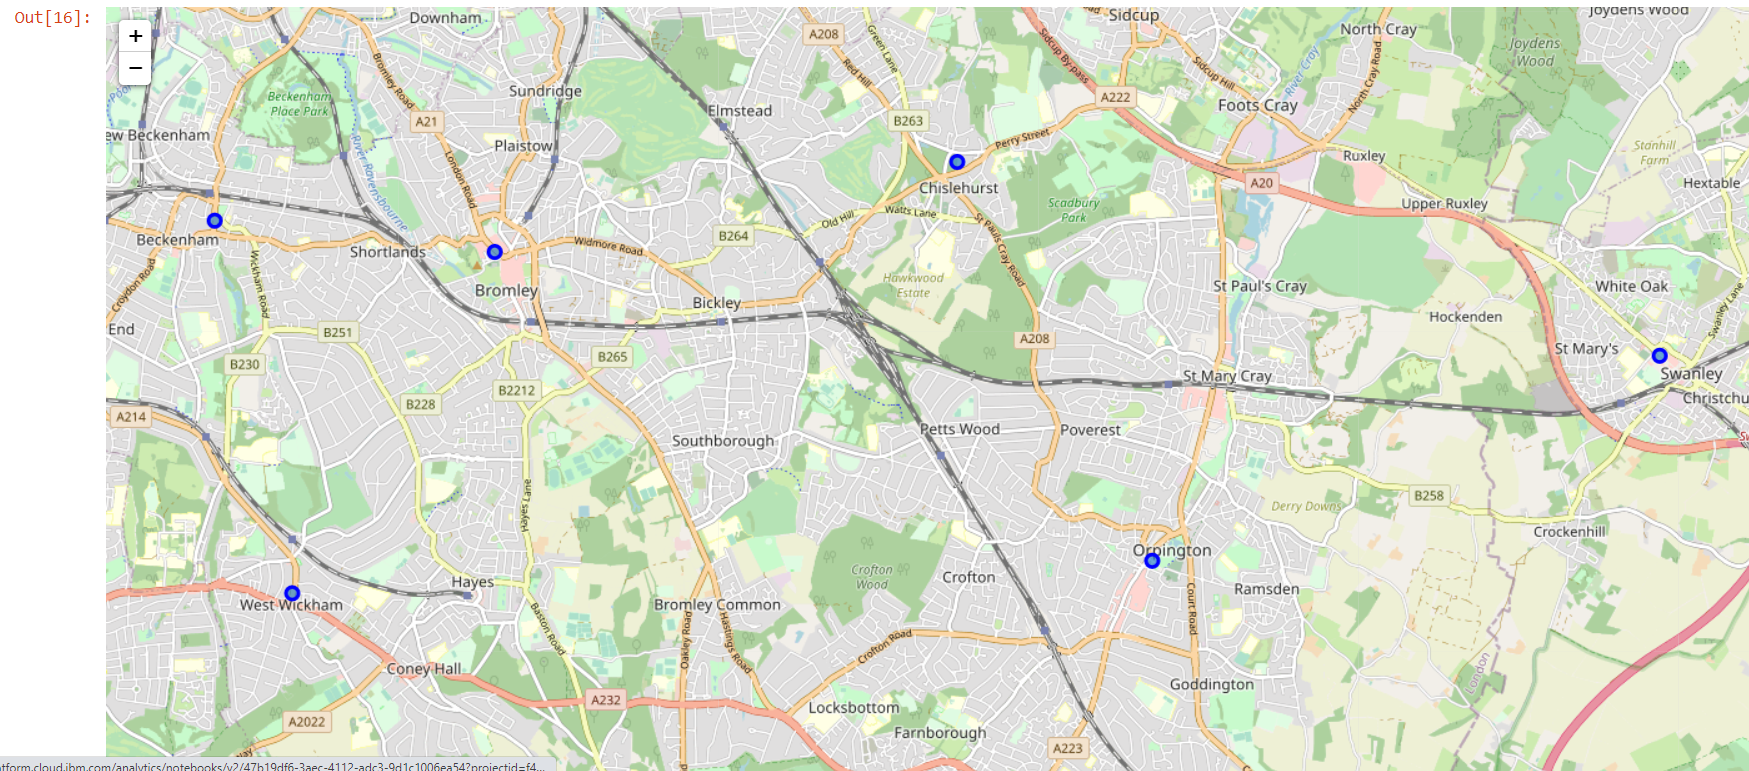

Define Foursquare Credentials and Version

In [17]:
CLIENT_ID = '' # my private Foursquare ID
CLIENT_SECRET = '' # my private Foursquare Secret
VERSION = '' # Foursquare API version
LIMIT = 100 # A default Foursquare API limit value

Using all Post town's name, latitude and longitude values, we create a function which gets the top 100 venues that are within a radius of 500 meters of each Post town.

In [18]:
def getNearbyVenues(names, latitudes, longitudes, radius=500):
    
    venues_list=[]
    for name, lat, lng in zip(names, latitudes, longitudes):
        print(name)
            
        # create the API request URL
        url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
            CLIENT_ID, 
            CLIENT_SECRET, 
            VERSION, 
            lat, 
            lng, 
            radius, 
            LIMIT)
            
        # make the GET request
        results = requests.get(url).json()["response"]['groups'][0]['items']
        
        # return only relevant information for each nearby venue
        venues_list.append([(
            name, 
            lat, 
            lng, 
            v['venue']['name'], 
            v['venue']['location']['lat'], 
            v['venue']['location']['lng'],  
            v['venue']['categories'][0]['name']) for v in results])

    nearby_venues = pd.DataFrame([item for venue_list in venues_list for item in venue_list])
    nearby_venues.columns = ['Post town', 
                  'Post town Latitude', 
                  'Post town Longitude', 
                  'Venue', 
                  'Venue Latitude', 
                  'Venue Longitude', 
                  'Venue Category']
    
    return(nearby_venues)

In [19]:
df2_Venues = getNearbyVenues(names=df2['Post town'],
                                   latitudes=df2['Latitude'],
                                   longitudes=df2['Longitude'])

BECKENHAM
BROMLEY
CHISLEHURST
ORPINGTON
SWANLEY
WEST WICKHAM


In [20]:
df2_Venues.head()

Post town  Post town Latitude  Post town Longitude  \
0  BECKENHAM            51.40878             -0.02526   
1  BECKENHAM            51.40878             -0.02526   
2  BECKENHAM            51.40878             -0.02526   
3  BECKENHAM            51.40878             -0.02526   
4  BECKENHAM            51.40878             -0.02526   

                             Venue  Venue Latitude  Venue Longitude  \
0  Ristorante Pizzeria Sapore Vero       51.408288        -0.025251   
1       Kelsey House Bar & Kitchen       51.407673        -0.025917   
2                      Breeze Yoga       51.410077        -0.023541   
3                       Caffè Nero       51.407498        -0.027477   
4             Em and Lou's Kitchen       51.409528        -0.025227   

       Venue Category  
0  Italian Restaurant  
1        Cocktail Bar  
2         Yoga Studio  
3         Coffee Shop  
4                Café

 Analyze Each post town's Venue Category using one hot encoding.

In [21]:
df2_onehot = pd.get_dummies(df2_Venues[['Venue Category']], prefix="", prefix_sep="")

df2_onehot['Post town'] = df2_Venues['Post town'] 

# move Post town column to the first column
fixed_columns = [df2_onehot.columns[-1]] + list(df2_onehot.columns[:-1])
df2_onehot = df2_onehot[fixed_columns]

df2_onehot.head()

Post town  Asian Restaurant  Auto Garage  Bakery  Bar  Bookstore  \
0  BECKENHAM                 0            0       0    0          0   
1  BECKENHAM                 0            0       0    0          0   
2  BECKENHAM                 0            0       0    0          0   
3  BECKENHAM                 0            0       0    0          0   
4  BECKENHAM                 0            0       0    0          0   

   Bridal Shop  Burger Joint  Café  Chocolate Shop  Clothing Store  \
0            0             0     0               0               0   
1            0             0     0               0               0   
2            0             0     0               0               0   
3            0             0     0               0               0   
4            0             0     1               0               0   

   Cocktail Bar  Coffee Shop  Deli / Bodega  Department Store  Dessert Shop  \
0             0            0              0                 0             0   
1             1            0              0                 0             0   
2             0            0              0                 0             0   
3             0            1              0                 0             0   
4             0            0              0                 0             0   

   Diner  Discount Store  Donut Shop  Electronics Store  Fast Food Restaurant  \
0      0               0           0                  0                     0   
1      0               0           0                  0                     0   
2      0               0           0                  0                     0   
3      0               0           0                  0                     0   
4      0               0           0                  0                     0   

   Fish & Chips Shop  Food  Furniture / Home Store  Gastropub  Gelato Shop  \
0                  0     0                       0          0            0   
1                  0     0                       0          0            0   
2                  0     0                       0          0            0   
3                  0     0                       0          0            0   
4                  0     0                       0          0            0   

   Grocery Store  Gym / Fitness Center  Hotel  Indian Restaurant  \
0              0                     0      0                  0   
1              0                     0      0                  0   
2              0                     0      0                  0   
3              0                     0      0                  0   
4              0                     0      0                  0   

   Indie Movie Theater  Irish Pub  Italian Restaurant  Kebab Restaurant  \
0                    0          0                   1                 0   
1                    0          0                   0                 0   
2                    0          0                   0                 0   
3                    0          0                   0                 0   
4                    0          0                   0                 0   

   Mediterranean Restaurant  Mexican Restaurant  Movie Theater  Newsagent  \
0                         0                   0              0          0   
1                         0                   0              0          0   
2                         0                   0              0          0   
3                         0                   0              0          0   
4                         0                   0              0          0   

   Nightclub  Noodle House  Park  Pharmacy  Pizza Place  Platform  \
0          0             0     0         0            0         0   
1          0             0     0         0            0         0   
2          0             0     0         0            0         0   
3          0             0     0         0            0         0   
4          0             0     0         0            0 

Group rows by Post town and by taking the mean of the frequency of occurrence of each category


In [22]:
df2_grouped = df2_onehot.groupby('Post town').mean().reset_index()
df2_grouped

Post town  Asian Restaurant  Auto Garage    Bakery       Bar  Bookstore  \
0     BECKENHAM          0.000000     0.000000  0.000000  0.043478   0.021739   
1       BROMLEY          0.022222     0.022222  0.000000  0.044444   0.022222   
2   CHISLEHURST          0.000000     0.000000  0.000000  0.000000   0.000000   
3     ORPINGTON          0.000000     0.000000  0.058824  0.000000   0.000000   
4       SWANLEY          0.000000     0.000000  0.000000  0.000000   0.000000   
5  WEST WICKHAM          0.000000     0.000000  0.055556  0.000000   0.000000   

   Bridal Shop  Burger Joint      Café  Chocolate Shop  Clothing Store  \
0     0.000000      0.021739  0.065217        0.000000        0.021739   
1     0.022222      0.044444  0.044444        0.022222        0.133333   
2     0.000000      0.000000  0.250000        0.000000        0.000000   
3     0.000000      0.000000  0.000000        0.000000        0.000000   
4     0.000000      0.000000  0.000000        0.000000        0.000000   
5     0.000000      0.000000  0.000000        0.000000        0.000000   

   Cocktail Bar  Coffee Shop  Deli / Bodega  Department Store  Dessert Shop  \
0      0.021739     0.086957       0.021739          0.000000      0.000000   
1      0.000000     0.088889       0.000000          0.022222      0.000000   
2      0.000000     0.000000       0.000000          0.000000      0.000000   
3      0.000000     0.000000       0.000000          0.000000      0.058824   
4      0.000000     0.200000       0.000000          0.000000      0.000000   
5      0.000000     0.055556       0.000000          0.000000      0.000000   

      Diner  Discount Store  Donut Shop  Electronics Store  \
0  0.021739        0.000000    0.000000           0.000000   
1  0.000000        0.000000    0.022222           0.022222   
2  0.000000        0.000000    0.000000           0.000000   
3  0.000000        0.058824    0.000000           0.000000   
4  0.000000        0.000000    0.000000           0.000000   
5  0.000000        0.000000    0.000000           0.000000   

   Fast Food Restaurant  Fish & Chips Shop      Food  Furniture / Home Store  \
0              0.021739           0.021739  0.000000                     0.0   
1              0.022222           0.000000  0.000000                     0.0   
2              0.000000           0.000000  0.000000                     0.0   
3              0.058824           0.000000  0.058824                     0.0   
4              0.200000           0.000000  0.000000                     0.2   
5              0.055556           0.000000  0.000000                     0.0   

   Gastropub  Gelato Shop  Grocery Store  Gym / Fitness Center     Hotel  \
0       0.00     0.000000       0.021739              0.000000  0.000000   
1       0.00     0.022222       0.000000              0.022222  0.000000   
2       0.25     0.000000       0.000000              0.000000  0.000000   
3       0.00     0.000000       0.058824              0.058824  0.058824   
4       0.00     0.000000       0.000000              0.000000  0.000000   
5       0.00     0.000000       0.055556              0.055556  0.000000   

   Indian Restaurant  Indie Movie Theater  Irish Pub  Italian Restaurant  \
0           0.021739             0.000000   0.043478            0.086957   
1           0.022222             0.022222   0.022222            0.000000   
2           0.000000             0.000000   0.000000            0.250000   
3           0.000000             0.000000   0.000000            0.000000   
4           0.200000             0.000000   0.000000            0.000000   
5           0.111111             0.000000   0.000000            0.000000   

   Kebab Restaurant  Mediterranean Restaurant  Mexican Restaurant  \
0          0.021739                  0.021739            0.000000   
1          0.000000                  0.000000            0.000000   
2          0.000000                  0.000000            0.000000   
3          0.000000        

Next we check the top 5 most frequent venue category for each post town.

In [23]:
num_top_venues = 5

for town in df2_grouped['Post town']:
    print("----"+town+"----")
    temp = df2_grouped[df2_grouped['Post town'] == town].T.reset_index()
    temp.columns = ['venue','freq']
    temp = temp.iloc[1:]
    temp['freq'] = temp['freq'].astype(float)
    temp = temp.round({'freq': 2})
    print(temp.sort_values('freq', ascending=False).reset_index(drop=True).head(num_top_venues))
    print('\n')

----BECKENHAM----
                venue  freq
0         Coffee Shop  0.09
1  Italian Restaurant  0.09
2         Supermarket  0.07
3                Café  0.07
4            Pharmacy  0.04


----BROMLEY----
            venue  freq
0  Clothing Store  0.13
1     Coffee Shop  0.09
2             Pub  0.07
3     Pizza Place  0.04
4             Bar  0.04


----CHISLEHURST----
                venue  freq
0  Italian Restaurant  0.25
1           Gastropub  0.25
2                Café  0.25
3                 Pub  0.25
4    Asian Restaurant  0.00


----ORPINGTON----
                   venue  freq
0         Discount Store  0.06
1   Fast Food Restaurant  0.06
2                   Food  0.06
3                   Park  0.06
4  Portuguese Restaurant  0.06


----SWANLEY----
                    venue  freq
0       Indian Restaurant   0.2
1  Furniture / Home Store   0.2
2    Fast Food Restaurant   0.2
3             Coffee Shop   0.2
4             Pizza Place   0.2


----WEST WICKHAM----
               venue  f

In [24]:
def return_most_common_venues(row, num_top_venues):
    row_categories = row.iloc[1:]
    row_categories_sorted = row_categories.sort_values(ascending=False)
    
    return row_categories_sorted.index.values[0:num_top_venues]

In [25]:
num_top_venues = 10

indicators = ['st', 'nd', 'rd']

# create columns according to number of top venues
columns = ['Post town']
for ind in np.arange(num_top_venues):
    try:
        columns.append('{}{} Most Common Venue'.format(ind+1, indicators[ind]))
    except:
        columns.append('{}th Most Common Venue'.format(ind+1))

# create a new dataframe
df2_venues_sorted = pd.DataFrame(columns=columns)
df2_venues_sorted['Post town'] = df2_grouped['Post town']

for ind in np.arange(df2_grouped.shape[0]):
    df2_venues_sorted.iloc[ind, 1:] = return_most_common_venues(df2_grouped.iloc[ind, :], num_top_venues)

df2_venues_sorted.head(7)

Post town 1st Most Common Venue   2nd Most Common Venue  \
0     BECKENHAM           Coffee Shop      Italian Restaurant   
1       BROMLEY        Clothing Store             Coffee Shop   
2   CHISLEHURST    Italian Restaurant               Gastropub   
3     ORPINGTON        Discount Store    Fast Food Restaurant   
4       SWANLEY     Indian Restaurant  Furniture / Home Store   
5  WEST WICKHAM           Supermarket       Indian Restaurant   

  3rd Most Common Venue 4th Most Common Venue  5th Most Common Venue  \
0           Supermarket                  Café               Pharmacy   
1                   Pub           Pizza Place                    Bar   
2                  Café                   Pub       Asian Restaurant   
3                  Food                  Park  Portuguese Restaurant   
4  Fast Food Restaurant           Coffee Shop            Pizza Place   
5           Pizza Place                   Pub              Newsagent   

  6th Most Common Venue 7th Most Common Venue     8th Most Common Venue  \
0              Platform             Irish Pub                       Bar   
1          Burger Joint                  Café                      Park   
2           Pizza Place      Kebab Restaurant  Mediterranean Restaurant   
3          Dessert Shop                   Pub                Restaurant   
4              Platform      Kebab Restaurant  Mediterranean Restaurant   
5           Coffee Shop  Fast Food Restaurant             Grocery Store   

  9th Most Common Venue 10th Most Common Venue  
0      Tapas Restaurant             Steakhouse  
1           Auto Garage    Indie Movie Theater  
2    Mexican Restaurant          Movie Theater  
3         Grocery Store            Supermarket  
4    Mexican Restaurant          Movie Theater  
5  Gym / Fitness Center          Train Station

In [26]:
# set number of clusters
kclusters = 6

df2_grouped_clustering = df2_grouped.drop('Post town', 1)

# run k-means clustering
kmeans = KMeans(n_clusters=kclusters, random_state=0).fit(df2_grouped_clustering)

# check cluster labels generated for each row in the dataframe
kmeans.labels_[0:10] 

/opt/conda/envs/Python-3.7-main/lib/python3.7/site-packages/ipykernel/__main__.py:4: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only


array([3, 5, 2, 1, 0, 4], dtype=int32)

In [27]:
# add clustering labels
df2_venues_sorted.insert(0, 'Cluster Labels', kmeans.labels_)

df2_merged = df2

# merge df2_venues with df2 to add the other information for each Post town
df2_merged = df2_merged.join(df2_venues_sorted.set_index('Post town'), on='Post town')

df2_merged.head() 

Postcode district    Post town   Latitude  Longitude Population  \
0               BR3    BECKENHAM  51.408780  -0.025260     47,411   
1           BR1,BR2      BROMLEY  51.406025   0.013156    100,920   
2               BR7  CHISLEHURST  51.413785   0.076756     17,322   
3           BR5,BR6    ORPINGTON  51.379588   0.103539     92,084   
4               BR8      SWANLEY  51.397170   0.173210     22,053   

   Cluster Labels 1st Most Common Venue   2nd Most Common Venue  \
0               3           Coffee Shop      Italian Restaurant   
1               5        Clothing Store             Coffee Shop   
2               2    Italian Restaurant               Gastropub   
3               1        Discount Store    Fast Food Restaurant   
4               0     Indian Restaurant  Furniture / Home Store   

  3rd Most Common Venue 4th Most Common Venue  5th Most Common Venue  \
0           Supermarket                  Café               Pharmacy   
1                   Pub           Pizza Place                    Bar   
2                  Café                   Pub       Asian Restaurant   
3                  Food                  Park  Portuguese Restaurant   
4  Fast Food Restaurant           Coffee Shop            Pizza Place   

  6th Most Common Venue 7th Most Common Venue     8th Most Common Venue  \
0              Platform             Irish Pub                       Bar   
1          Burger Joint                  Café                      Park   
2           Pizza Place      Kebab Restaurant  Mediterranean Restaurant   
3          Dessert Shop                   Pub                Restaurant   
4              Platform      Kebab Restaurant  Mediterranean Restaurant   

  9th Most Common Venue 10th Most Common Venue  
0      Tapas Restaurant             Steakhouse  
1           Auto Garage    Indie Movie Theater  
2    Mexican Restaurant          Movie Theater  
3         Grocery Store            Supermarket  
4    Mexican Restaurant          Movie Theater

In [28]:
# create map
map_clusters = folium.Map(location=[latitude, longitude], zoom_start=11)

# set color scheme for the clusters
x = np.arange(kclusters)
ys = [i + x + (i*x)**2 for i in range(kclusters)]
colors_array = cm.rainbow(np.linspace(0, 1, len(ys)))
rainbow = [colors.rgb2hex(i) for i in colors_array]

# add markers to the map
markers_colors = []
for lat, lon, poi, cluster in zip(df2_merged['Latitude'], df2_merged['Longitude'], df2_merged['Post town'], df2_merged['Cluster Labels']):
    label = folium.Popup(str(poi) + ' Cluster ' + str(cluster), parse_html=True)
    folium.CircleMarker(
        [lat, lon],
        radius=5,
        popup=label,
        color=rainbow[cluster-1],
        fill=True,
        fill_color=rainbow[cluster-1],
        fill_opacity=0.7).add_to(map_clusters)
       
map_clusters

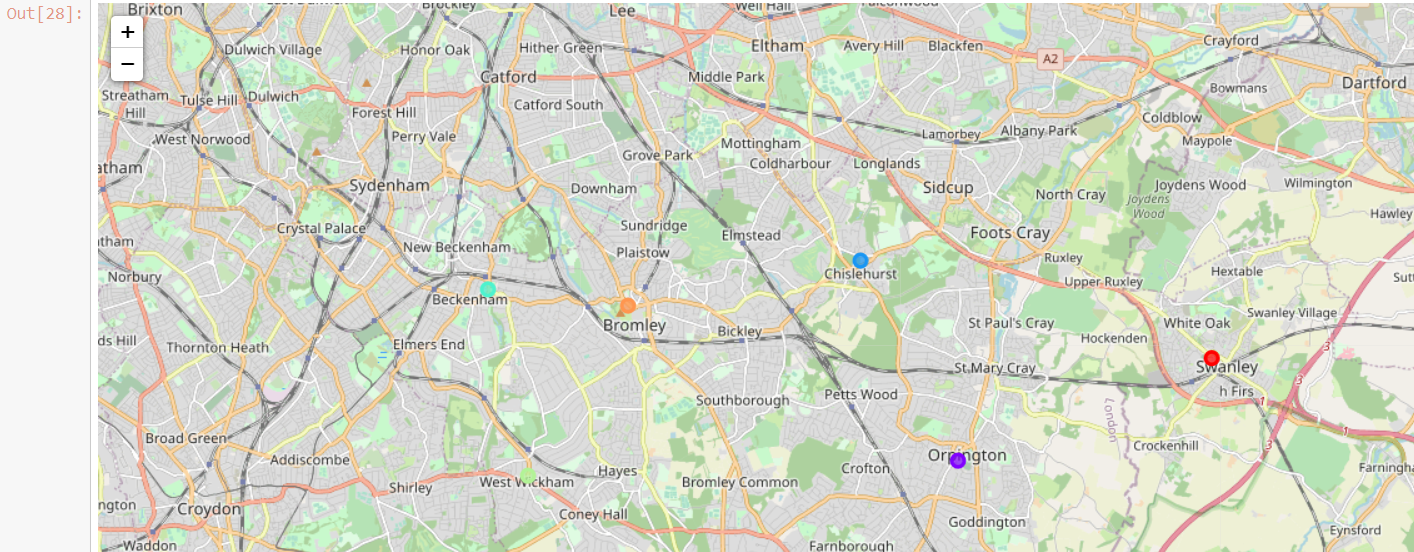

Cluster 1

In [29]:
df2_merged.loc[df2_merged['Cluster Labels'] == 0, df2_merged.columns[[1] + list(range(5, df2_merged.shape[1]))]]

Post town  Cluster Labels 1st Most Common Venue   2nd Most Common Venue  \
4   SWANLEY               0     Indian Restaurant  Furniture / Home Store   

  3rd Most Common Venue 4th Most Common Venue 5th Most Common Venue  \
4  Fast Food Restaurant           Coffee Shop           Pizza Place   

  6th Most Common Venue 7th Most Common Venue     8th Most Common Venue  \
4              Platform      Kebab Restaurant  Mediterranean Restaurant   

  9th Most Common Venue 10th Most Common Venue  
4    Mexican Restaurant          Movie Theater

Cluster 2

In [30]:
df2_merged.loc[df2_merged['Cluster Labels'] == 1, df2_merged.columns[[1] + list(range(5, df2_merged.shape[1]))]]

Post town  Cluster Labels 1st Most Common Venue 2nd Most Common Venue  \
3  ORPINGTON               1        Discount Store  Fast Food Restaurant   

  3rd Most Common Venue 4th Most Common Venue  5th Most Common Venue  \
3                  Food                  Park  Portuguese Restaurant   

  6th Most Common Venue 7th Most Common Venue 8th Most Common Venue  \
3          Dessert Shop                   Pub            Restaurant   

  9th Most Common Venue 10th Most Common Venue  
3         Grocery Store            Supermarket

Cluster 3

In [31]:
df2_merged.loc[df2_merged['Cluster Labels'] == 2, df2_merged.columns[[1] + list(range(5, df2_merged.shape[1]))]]

Post town  Cluster Labels 1st Most Common Venue 2nd Most Common Venue  \
2  CHISLEHURST               2    Italian Restaurant             Gastropub   

  3rd Most Common Venue 4th Most Common Venue 5th Most Common Venue  \
2                  Café                   Pub      Asian Restaurant   

  6th Most Common Venue 7th Most Common Venue     8th Most Common Venue  \
2           Pizza Place      Kebab Restaurant  Mediterranean Restaurant   

  9th Most Common Venue 10th Most Common Venue  
2    Mexican Restaurant          Movie Theater

Cluster 4

In [32]:
df2_merged.loc[df2_merged['Cluster Labels'] == 3, df2_merged.columns[[1] + list(range(5, df2_merged.shape[1]))]]

Post town  Cluster Labels 1st Most Common Venue 2nd Most Common Venue  \
0  BECKENHAM               3           Coffee Shop    Italian Restaurant   

  3rd Most Common Venue 4th Most Common Venue 5th Most Common Venue  \
0           Supermarket                  Café              Pharmacy   

  6th Most Common Venue 7th Most Common Venue 8th Most Common Venue  \
0              Platform             Irish Pub                   Bar   

  9th Most Common Venue 10th Most Common Venue  
0      Tapas Restaurant             Steakhouse

Cluster 5

In [33]:
df2_merged.loc[df2_merged['Cluster Labels'] == 4, df2_merged.columns[[1] + list(range(5, df2_merged.shape[1]))]]

Post town  Cluster Labels 1st Most Common Venue 2nd Most Common Venue  \
5  WEST WICKHAM               4           Supermarket     Indian Restaurant   

  3rd Most Common Venue 4th Most Common Venue 5th Most Common Venue  \
5           Pizza Place                   Pub             Newsagent   

  6th Most Common Venue 7th Most Common Venue 8th Most Common Venue  \
5           Coffee Shop  Fast Food Restaurant         Grocery Store   

  9th Most Common Venue 10th Most Common Venue  
5  Gym / Fitness Center          Train Station

Cluster 6

In [34]:
df2_merged.loc[df2_merged['Cluster Labels'] == 5, df2_merged.columns[[1] + list(range(5, df2_merged.shape[1]))]]

Post town  Cluster Labels 1st Most Common Venue 2nd Most Common Venue  \
1   BROMLEY               5        Clothing Store           Coffee Shop   

  3rd Most Common Venue 4th Most Common Venue 5th Most Common Venue  \
1                   Pub           Pizza Place                   Bar   

  6th Most Common Venue 7th Most Common Venue 8th Most Common Venue  \
1          Burger Joint                  Café                  Park   

  9th Most Common Venue 10th Most Common Venue  
1           Auto Garage    Indie Movie Theater

In [37]:
df2_Venues['Venue Category'].unique()   #Here we get all unique Venue categories.

array(['Italian Restaurant', 'Cocktail Bar', 'Yoga Studio', 'Coffee Shop',
       'Café', 'Fish & Chips Shop', 'Tapas Restaurant', 'Grocery Store',
       'Supermarket', 'Park', 'Mediterranean Restaurant', 'Diner',
       'Indian Restaurant', 'Pub', 'Kebab Restaurant', 'Clothing Store',
       'Tram Station', 'Deli / Bodega', 'Pharmacy',
       'Portuguese Restaurant', 'Steakhouse', 'Nightclub', 'Bar',
       'Newsagent', 'Movie Theater', 'Pizza Place',
       'Fast Food Restaurant', 'Bookstore', 'Platform', 'Irish Pub',
       'Burger Joint', 'Train Station', 'Turkish Restaurant',
       'Indie Movie Theater', 'Department Store', 'Electronics Store',
       'Gelato Shop', 'Asian Restaurant', 'Donut Shop', 'Sandwich Place',
       'Gym / Fitness Center', 'Sushi Restaurant', 'Chocolate Shop',
       'Seafood Restaurant', 'Noodle House', 'Auto Garage', 'Bridal Shop',
       'Gastropub', 'Food', 'Restaurant', 'Bakery', 'Mexican Restaurant',
       'Hotel', 'Dessert Shop', 'Discount Store'

In [38]:
#next we explore further specific categories which may have an impact on the profitability of coffee shops
df2_SUM_grouped = df2_onehot.groupby('Post town').sum().reset_index()
df2_SUM_grouped_filter= df2_SUM_grouped[['Post town','Auto Garage','Bakery','Café','Chocolate Shop','Clothing Store','Coffee Shop','Department Store',
                                         'Donut Shop','Electronics Store','Furniture / Home Store','Gelato Shop','Grocery Store','Hotel',
                                         'Movie Theater','Park','Pharmacy','Sandwich Place','Supermarket','Train Station','Tram Station']]
df2_SUM_grouped_filter

Post town  Auto Garage  Bakery  Café  Chocolate Shop  Clothing Store  \
0     BECKENHAM            0       0     3               0               1   
1       BROMLEY            1       0     2               1               6   
2   CHISLEHURST            0       0     1               0               0   
3     ORPINGTON            0       1     0               0               0   
4       SWANLEY            0       0     0               0               0   
5  WEST WICKHAM            0       1     0               0               0   

   Coffee Shop  Department Store  Donut Shop  Electronics Store  \
0            4                 0           0                  0   
1            4                 1           1                  1   
2            0                 0           0                  0   
3            0                 0           0                  0   
4            1                 0           0                  0   
5            1                 0           0                  0   

   Furniture / Home Store  Gelato Shop  Grocery Store  Hotel  Movie Theater  \
0                       0            0              1      0              1   
1                       0            1              0      0              0   
2                       0            0              0      0              0   
3                       0            0              1      1              1   
4                       1            0              0      0              0   
5                       0            0              1      0              0   

   Park  Pharmacy  Sandwich Place  Supermarket  Train Station  Tram Station  
0     1         2               0            3              1             1  
1     2         1               1            1              0             0  
2     0         0               0            0              0             0  
3     1         1               0            1              0             0  
4     0         0               0            0              0             0  
5     0         1               0            3              1             0

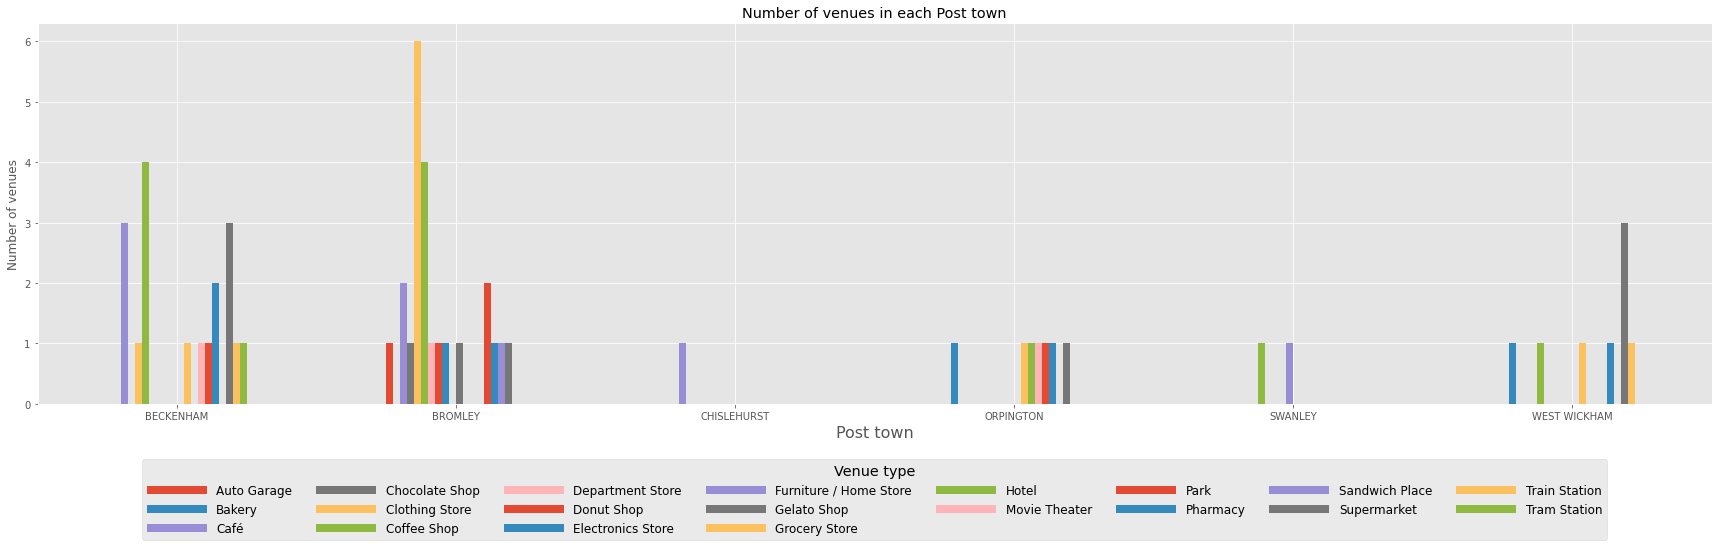

In [39]:
# use the inline backend to generate the plots within the browser
%matplotlib inline 
import matplotlib as mpl
import matplotlib.pyplot as plt
mpl.style.use('ggplot') # optional: for ggplot-like style

df2_SUM_grouped_filter=df2_SUM_grouped_filter.set_index('Post town')
df2_SUM_grouped_filter.plot(kind='bar', figsize=(30, 7))
plt.legend(loc = "upper center",handlelength=5, prop={"size":12},title="Venue type",title_fontsize="x-large",ncol=8, bbox_to_anchor=(0.5,-0.13))#bbox_to_anchor moves it below
plt.xlabel('Post town',fontsize=16) # add to x-label to the plot
plt.xticks(rotation = 0)# rotates x labels to make them horizontal
plt.ylabel('Number of venues') # add y-label to the plot
plt.title('Number of venues in each Post town') # add title to the plot


plt.show()

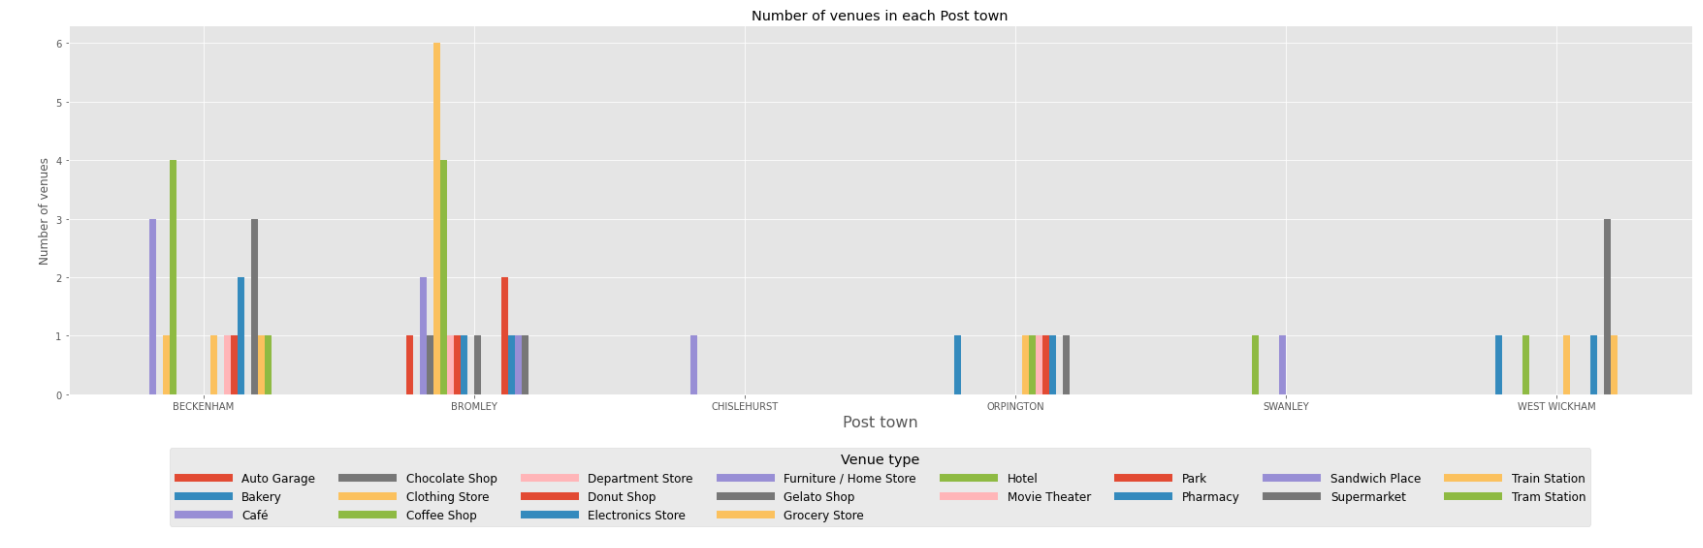

In [40]:
#A more detailed analysis on direct competitors
types=['Coffee Shop','Café']
CoffeeShops = df2_Venues['Venue Category'].isin(types)
CoffeeShops.head()

0    False
1    False
2    False
3     True
4     True
Name: Venue Category, dtype: bool

In [41]:
df2_Venues[CoffeeShops]

Post town  Post town Latitude  Post town Longitude  \
3       BECKENHAM           51.408780            -0.025260   
4       BECKENHAM           51.408780            -0.025260   
8       BECKENHAM           51.408780            -0.025260   
15      BECKENHAM           51.408780            -0.025260   
17      BECKENHAM           51.408780            -0.025260   
24      BECKENHAM           51.408780            -0.025260   
35      BECKENHAM           51.408780            -0.025260   
55        BROMLEY           51.406025             0.013156   
66        BROMLEY           51.406025             0.013156   
67        BROMLEY           51.406025             0.013156   
70        BROMLEY           51.406025             0.013156   
74        BROMLEY           51.406025             0.013156   
88        BROMLEY           51.406025             0.013156   
94    CHISLEHURST           51.413785             0.076756   
113       SWANLEY           51.397170             0.173210   
117  WEST WICKHAM           51.376826            -0.014540   

                    Venue  Venue Latitude  Venue Longitude Venue Category  
3              Caffè Nero       51.407498        -0.027477    Coffee Shop  
4    Em and Lou's Kitchen       51.409528        -0.025227           Café  
8        Rendez-Vous Cafe       51.408005        -0.025303           Café  
15            Fee & Brown       51.409188        -0.025156    Coffee Shop  
17              Starbucks       51.406618        -0.028772    Coffee Shop  
24         Love 'A' Slice       51.406668        -0.030324           Café  
35           Costa Coffee       51.406864        -0.028106    Coffee Shop  
55           Costa Coffee       51.405653         0.015279    Coffee Shop  
66           Costa Coffee       51.404458         0.016645    Coffee Shop  
67     Patisserie Valerie       51.405164         0.016470           Café  
70             Caffè Nero       51.402653         0.015616    Coffee Shop  
74              Starbucks       51.405300         0.015538    Coffee Shop  
88           Buddy's Cafe       51.409293         0.010537           Café  
94    Walnuts Cafe Bistro       51.411776         0.075298           Café  
113          Costa Coffee       51.396743         0.173980    Coffee Shop  
117            Caffè Nero       51.376183        -0.017538    Coffee Shop

In [42]:
CountPostTown=df2_Venues[CoffeeShops]['Post town'].value_counts()
CountPostTown

BECKENHAM       7
BROMLEY         6
CHISLEHURST     1
SWANLEY         1
WEST WICKHAM    1
Name: Post town, dtype: int64

In [43]:
#Covert the above into dataframe
d8 = df2_Venues[CoffeeShops]['Post town'].value_counts().rename_axis('Post town').reset_index(name='Competitors')
d8

Post town  Competitors
0     BECKENHAM            7
1       BROMLEY            6
2   CHISLEHURST            1
3       SWANLEY            1
4  WEST WICKHAM            1

We then join d8 which includes the number of coffee shops, with the rest data.
Also, replace NaN with 0

In [44]:
df2Index = df2.set_index('Post town')
d8Index = d8.set_index('Post town')
df_final = pd.concat([df2Index, d8Index], axis=1, join='outer')

df_final.index.name = 'Post town'
df_final.reset_index(inplace=True)

df_final.head(10)
df_final['Competitors'].fillna(value=0,inplace=True)
df_final['Population']=df_final['Population'].str.replace(',','')
df_final['Population']=df_final['Population'].astype(int)
df_final['Competitors']=df_final['Competitors'].astype(int)
df_final

Post town Postcode district   Latitude  Longitude  Population  \
0     BECKENHAM               BR3  51.408780  -0.025260       47411   
1       BROMLEY           BR1,BR2  51.406025   0.013156      100920   
2   CHISLEHURST               BR7  51.413785   0.076756       17322   
3     ORPINGTON           BR5,BR6  51.379588   0.103539       92084   
4       SWANLEY               BR8  51.397170   0.173210       22053   
5  WEST WICKHAM               BR4  51.376826  -0.014540       19367   

   Competitors  
0            7  
1            6  
2            1  
3            0  
4            1  
5            1

In [45]:
#next we calculate coffee shops per capita for each post town, assuming equal customer base for each direct competitor
df_final['Coffee shops per capita']=df_final['Population'] / (df_final['Competitors'] + 1)
df_final


Post town Postcode district   Latitude  Longitude  Population  \
0     BECKENHAM               BR3  51.408780  -0.025260       47411   
1       BROMLEY           BR1,BR2  51.406025   0.013156      100920   
2   CHISLEHURST               BR7  51.413785   0.076756       17322   
3     ORPINGTON           BR5,BR6  51.379588   0.103539       92084   
4       SWANLEY               BR8  51.397170   0.173210       22053   
5  WEST WICKHAM               BR4  51.376826  -0.014540       19367   

   Competitors  Coffee shops per capita  
0            7              5926.375000  
1            6             14417.142857  
2            1              8661.000000  
3            0             92084.000000  
4            1             11026.500000  
5            1              9683.500000

In [46]:
df_final3= df_final[['Post town','Coffee shops per capita']]
df_final3=df_final3.set_index('Post town')
df_final3

Coffee shops per capita
Post town                            
BECKENHAM                 5926.375000
BROMLEY                  14417.142857
CHISLEHURST               8661.000000
ORPINGTON                92084.000000
SWANLEY                  11026.500000
WEST WICKHAM              9683.500000

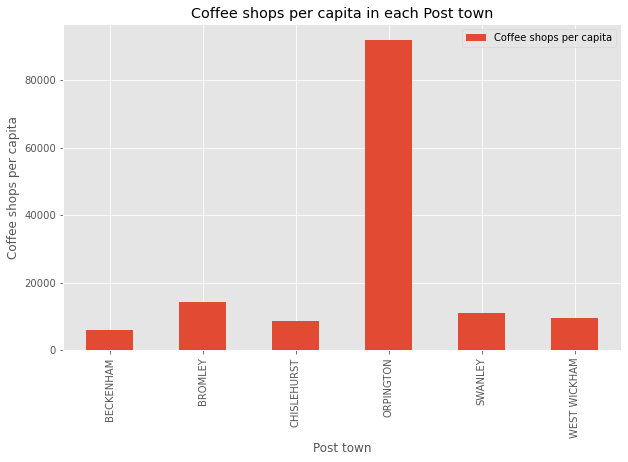

In [47]:
# plot data
df_final3.plot(kind='bar', figsize=(10, 6))

plt.xlabel('Post town') # add to x-label to the plot
plt.ylabel('Coffee shops per capita') # add y-label to the plot
plt.title('Coffee shops per capita in each Post town') # add title to the plot

plt.show()

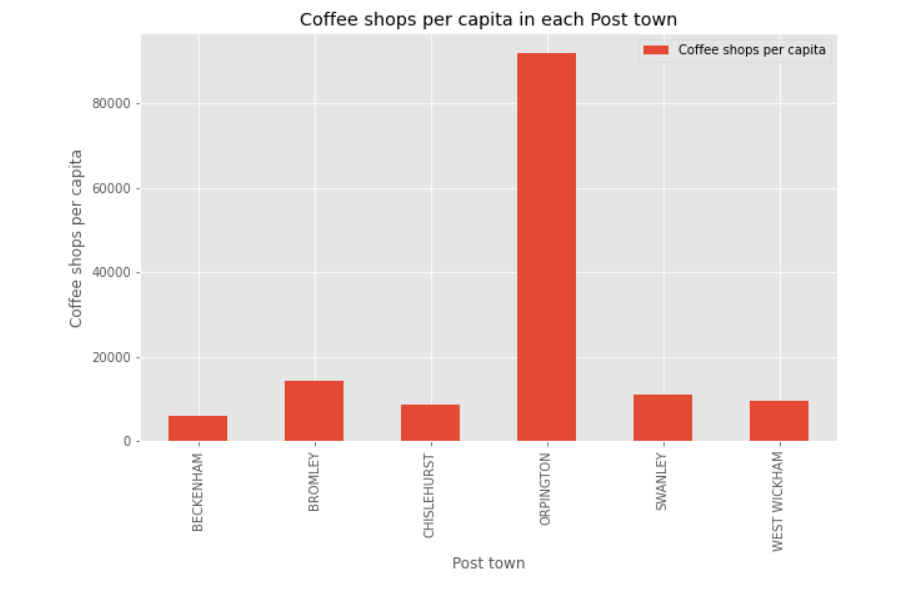